## Import

In [1]:
import numpy as np
import random
import matplotlib.pyplot as plt
import classify
import importlib
import preprocess

np.random.seed(42)
random.seed(42)

# reload when updating code
importlib.reload(preprocess)
importlib.reload(classify)

# Load the data
data = np.load('/Users/sander/PhD/reactivation/andermann_data/NN11/NN11_210626_processed_all.npz', allow_pickle=True)
idx, norm_deconvolved, y_pred = data['idx'], data['norm_deconvolved'], data['y_pred']

mice = ['NN11']
dates_per_mouse = {'NN11': ['210626']}

for mouse in mice:
    for date in dates_per_mouse[mouse]:
        paths = preprocess.create_folders(mouse, date)
        session_data = preprocess.load_data(paths)
        behavior = preprocess.process_behavior(session_data, paths)

## Process stimuli and reactivations

In [2]:
def get_stimuli_and_reactivations_from_data(norm_deconvolved, y_pred):
    # Stimuli
    mean_activity_cs_1 = []
    mean_activity_cs_2 = []
    onsets_cs_1 = []
    onsets_cs_2 = []
    for i in range(0, len(behavior['onsets'])):
        temp_activity = np.mean(norm_deconvolved[:, int(behavior['onsets'][i]):int(behavior['offsets'][i]) + 1], axis=1)
        if behavior['cue_codes'][i] == behavior['cs_1_code']:
            mean_activity_cs_1.append(temp_activity)
            onsets_cs_1.append(behavior['onsets'][i])
        if behavior['cue_codes'][i] == behavior['cs_2_code']:
            mean_activity_cs_2.append(temp_activity)
            onsets_cs_2.append(behavior['onsets'][i])

    early_cs1, late_cs1 = np.mean(mean_activity_cs_1[0:3], axis=0), np.mean(mean_activity_cs_1[len(mean_activity_cs_1) - 3:len(mean_activity_cs_1)], axis=0)
    early_cs2, late_cs2  = np.mean(mean_activity_cs_2[0:3], axis=0), np.mean(mean_activity_cs_2[len(mean_activity_cs_2) - 3:len(mean_activity_cs_2)], axis=0)

    # Reactivations
    mean_activity_r_1 = []
    mean_activity_r_2 = []
    trial_r_1 = []
    trial_r_2 = []
    reactivation_cs_1 = y_pred[:, 0].copy()
    reactivation_cs_2 = y_pred[:, 1].copy()
    p_threshold = .75
    cs_1_peak = 0
    cs_2_peak = 0
    i = 0
    next_r = 0
    while i < len(reactivation_cs_1) - 1:
        i += 1
        if reactivation_cs_1[i] > 0 or reactivation_cs_2[i] > 0:
            if next_r == 0:
                r_start = i
                next_r = 1
            if reactivation_cs_1[i] > cs_1_peak:
                cs_1_peak = reactivation_cs_1[i]
            if reactivation_cs_2[i] > cs_2_peak:
                cs_2_peak = reactivation_cs_2[i]
            if reactivation_cs_1[i + 1] == 0 and reactivation_cs_2[i + 1] == 0:
                r_end = i + 1
                next_r = 0
                if cs_1_peak > p_threshold:
                    for j in range(0, len(onsets_cs_1)):
                        if r_start < onsets_cs_1[j] and r_start > onsets_cs_1[j-1] and r_start < onsets_cs_1[j-1] + int(behavior['framerate']*61):
                            mean_activity_r_1.append(np.mean(norm_deconvolved[:, r_start:r_end], axis=1))
                            trial_r_1.append(j-1)
                            break
                if cs_2_peak > p_threshold:
                    for j in range(0, len(onsets_cs_2)):
                        if r_start < onsets_cs_2[j] and r_start > onsets_cs_2[j-1] and r_start < onsets_cs_2[j-1] + int(behavior['framerate']*61):
                            mean_activity_r_2.append(np.mean(norm_deconvolved[:, r_start:r_end], axis=1))
                            trial_r_2.append(j-1)
                            break
                i = r_end
                cs_1_peak = 0
                cs_2_peak = 0

    mean_activity_cs_1 = np.stack(mean_activity_cs_1, axis=0)
    mean_activity_cs_2 = np.stack(mean_activity_cs_2, axis=0)

    mean_activity_r_1 = np.stack(mean_activity_r_1, axis=0)
    mean_activity_r_2 = np.stack(mean_activity_r_2, axis=0)

    return mean_activity_cs_1, mean_activity_cs_2, mean_activity_r_1, mean_activity_r_2, trial_r_1, trial_r_2, early_cs1, late_cs1, early_cs2, late_cs2

mean_activity_cs_1, mean_activity_cs_2, mean_activity_r_1, mean_activity_r_2, trial_r_1, trial_r_2, early_cs1, late_cs1, early_cs2, late_cs2 = get_stimuli_and_reactivations_from_data(norm_deconvolved, y_pred)

In [459]:
# Early to late vectors
early_to_late_cs1 = late_cs1 - early_cs1
early_to_late_cs2 = late_cs2 - early_cs2

## PCA

In [556]:
from sklearn.decomposition import PCA

topn = 1.0

top_n_1_idxs = np.argsort(late_cs1)[-int(len(late_cs1) * topn):]
top_n_2_idxs = np.argsort(late_cs2)[-int(len(late_cs2) * topn):]

mean_activity_cstopn_1 = mean_activity_cs_1[:, top_n_1_idxs]
mean_activity_cstopn_2 = mean_activity_cs_2[:, top_n_2_idxs]
mean_activity_rtopn_1 = mean_activity_r_1[:, top_n_1_idxs]
mean_activity_rtopn_2 = mean_activity_r_2[:, top_n_2_idxs]
early_topn_1 = early_cs1[top_n_1_idxs]
early_topn_2 = early_cs2[top_n_2_idxs]
late_topn_1 = late_cs1[top_n_1_idxs]
late_topn_2 = late_cs2[top_n_2_idxs]

early_to_late_1 = late_topn_1 - early_topn_1
early_to_late_2 = late_topn_2 - early_topn_2
early_to_late_1_unit = early_to_late_1 / np.linalg.norm(early_to_late_1)
early_to_late_2_unit = early_to_late_2 / np.linalg.norm(early_to_late_2)

cs_1_centered = (mean_activity_cstopn_1 - early_topn_1) / np.linalg.norm(early_to_late_1)
cs_2_centered = (mean_activity_cstopn_2 - early_topn_2) / np.linalg.norm(early_to_late_2)
r_1_centered = (mean_activity_rtopn_1 - early_topn_1) / np.linalg.norm(early_to_late_1)
r_2_centered = (mean_activity_rtopn_2 - early_topn_2) / np.linalg.norm(early_to_late_2)

proj_cs_1 = np.dot(cs_1_centered, early_to_late_1_unit)  
proj_cs_2 = np.dot(cs_2_centered, early_to_late_2_unit)
proj_r_1 = np.dot(r_1_centered, early_to_late_1_unit)
proj_r_2 = np.dot(r_2_centered, early_to_late_2_unit)

residual_cs_1 = cs_1_centered - np.outer(proj_cs_1, early_to_late_1_unit)
residual_cs_2 = cs_2_centered - np.outer(proj_cs_2, early_to_late_2_unit)
residual_r_1 = r_1_centered - np.outer(proj_r_1, early_to_late_1_unit)
residual_r_2 = r_2_centered - np.outer(proj_r_2, early_to_late_2_unit)

pca_1 = PCA(n_components=1)
pca_2 = PCA(n_components=1)
pca_1.fit(residual_cs_1)
pca_2.fit(residual_cs_2)

pc_cs_1 = pca_1.transform(residual_cs_1)
pc_cs_2 = pca_2.transform(residual_cs_2)
pc_r_1 = pca_1.transform(residual_r_1)
pc_r_2 = pca_2.transform(residual_r_2)

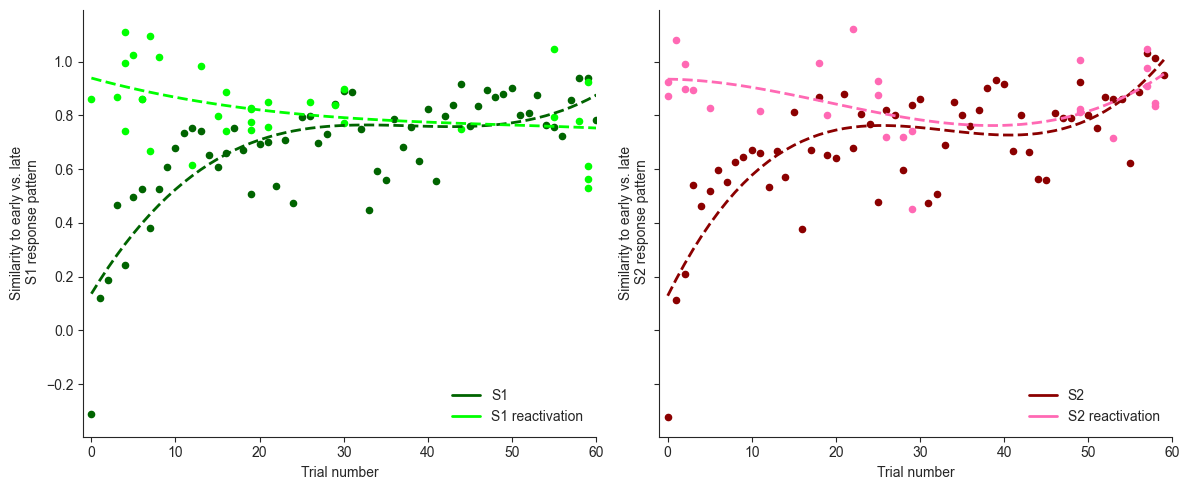

In [557]:
import seaborn as sns
import matplotlib.lines as mlines
import matplotlib.pyplot as plt
import numpy as np

sns.set_style("whitegrid", {'axes.grid': False})
sns.set_style("ticks")

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 5), sharex=True, sharey=True)
m_size = 20
degree = 3

# S1
x_cs1 = np.arange(len(proj_cs_1))
x_r1 = np.array(trial_r_1)
y_cs1 = proj_cs_1
y_r1 = proj_r_1

axes[0].scatter(x_cs1, y_cs1, color='darkgreen', s=m_size)
axes[0].scatter(x_r1, y_r1, color='lime', s=m_size)

# Fit and plot regression for CS1
coef_cs1 = np.polyfit(x_cs1, y_cs1, degree)
poly_cs1 = np.poly1d(coef_cs1)
axes[0].plot(x_cs1, poly_cs1(x_cs1), color='darkgreen', linewidth=2, linestyle='--')

# Fit and plot regression for R1 over all trial numbers in CS1
if len(x_r1) > 0:
    coef_r1 = np.polyfit(x_r1, y_r1, degree)
    poly_r1 = np.poly1d(coef_r1)
    axes[0].plot(x_cs1, poly_r1(x_cs1), color='lime', linewidth=2, linestyle='--')

axes[0].set_xlim(-1, 60)
axes[0].set_ylabel('Similarity to early vs. late\n S1 response pattern')
axes[0].set_xlabel('Trial number')
label_1 = mlines.Line2D([], [], color='darkgreen', linewidth=2, label='S1')
label_2 = mlines.Line2D([], [], color='lime', linewidth=2, label='S1 reactivation')
axes[0].legend(handles=[label_1, label_2], frameon=False)

# S2
x_cs2 = np.arange(len(proj_cs_2))
x_r2 = np.array(trial_r_2)
y_cs2 = proj_cs_2
y_r2 = proj_r_2

axes[1].scatter(x_cs2, y_cs2, color='darkred', s=m_size)
axes[1].scatter(x_r2, y_r2, color='hotpink', s=m_size)

# Fit and plot regression for CS2
coef_cs2 = np.polyfit(x_cs2, y_cs2, degree)
poly_cs2 = np.poly1d(coef_cs2)
axes[1].plot(x_cs2, poly_cs2(x_cs2), color='darkred', linewidth=2, linestyle='--')

# Fit and plot regression for R2 over all trial numbers in CS2
if len(x_r2) > 0:
    coef_r2 = np.polyfit(x_r2, y_r2, degree)
    poly_r2 = np.poly1d(coef_r2)
    axes[1].plot(x_cs2, poly_r2(x_cs2), color='hotpink', linewidth=2, linestyle='--')

axes[1].set_ylabel('Similarity to early vs. late\n S2 response pattern')
axes[1].set_xlabel('Trial number')
label_1 = mlines.Line2D([], [], color='darkred', linewidth=2, label='S2')
label_2 = mlines.Line2D([], [], color='hotpink', linewidth=2, label='S2 reactivation')
axes[1].legend(handles=[label_1, label_2], frameon=False)

fig.savefig("similarity.svg", format="svg")

sns.despine()
plt.tight_layout()
plt.show()


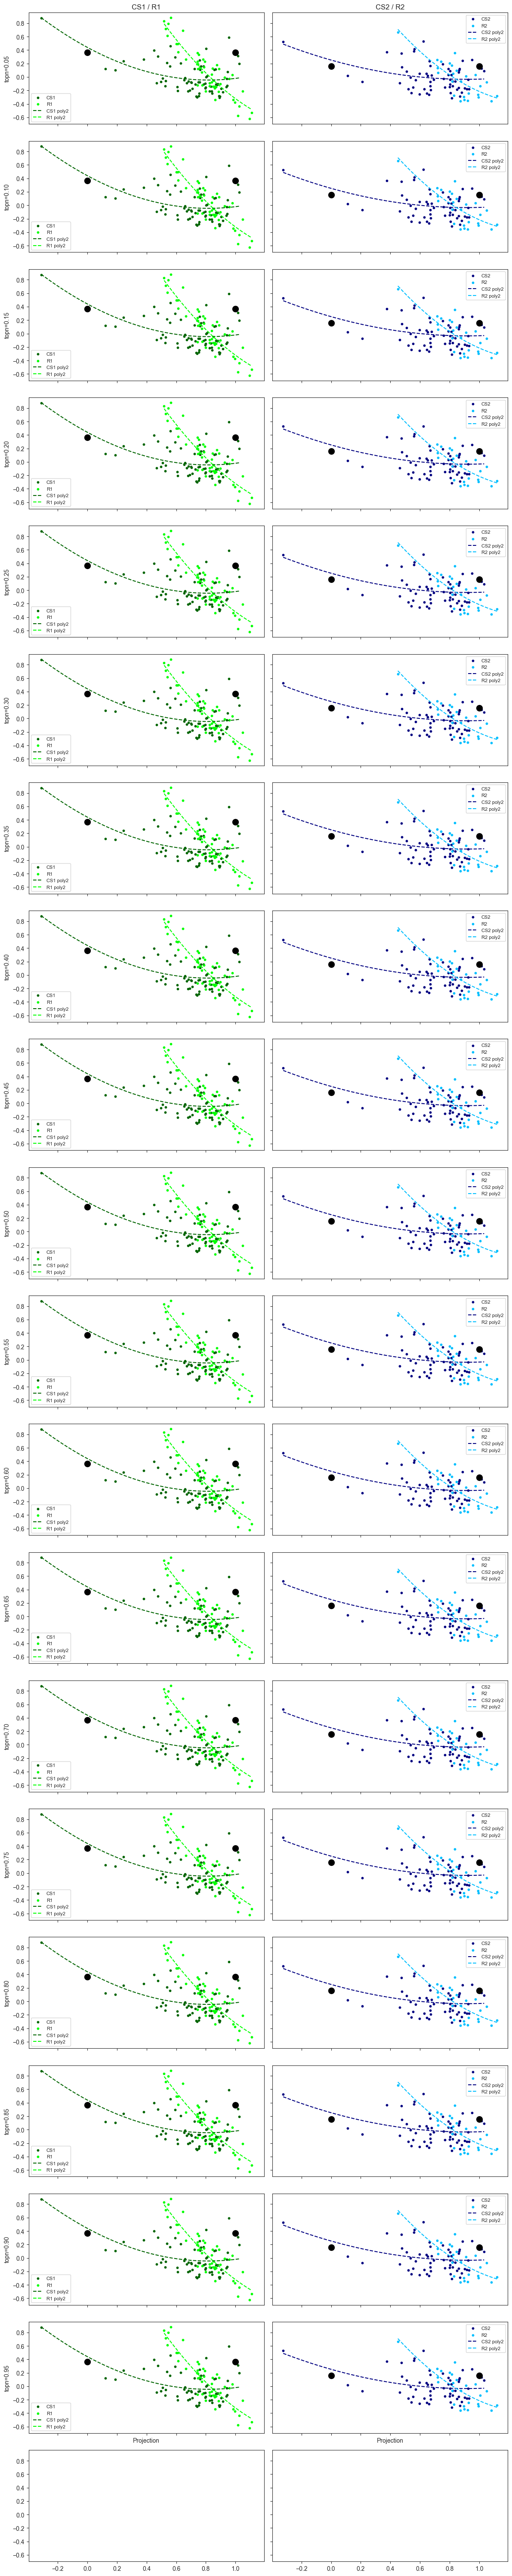

In [558]:
fig, axes = plt.subplots(nrows=20, ncols=2, figsize=(12, 60), sharex=True, sharey=True)
topn_values = np.arange(0.05, 1, 0.05)
degree = 2

for i, topn in enumerate(topn_values):
    # First column: cs_1 / r_1
    axes[i, 0].scatter(proj_cs_1, pc_cs_1, color='darkgreen', s=10, label='CS1')
    axes[i, 0].scatter(proj_r_1, pc_r_1, color='lime', s=10, label='R1')
    axes[i, 0].plot(np.mean(proj_cs_1[0:3]), np.mean(pc_cs_1[0:3]), color='k', marker='o', markersize=10)
    axes[i, 0].plot(np.mean(proj_cs_1[-3:]), np.mean(pc_cs_1[-3:]), color='k', marker='o', markersize=10)
    axes[i, 0].set_ylabel(f'topn={topn:.2f}')

    # Polyfit for CS1
    coeffs_cs1 = np.polyfit(proj_cs_1, pc_cs_1, degree)
    x_fit_cs1 = np.linspace(proj_cs_1.min(), proj_cs_1.max(), 100)
    y_fit_cs1 = np.polyval(coeffs_cs1, x_fit_cs1)
    axes[i, 0].plot(x_fit_cs1, y_fit_cs1, color='darkgreen', linestyle='--', label='CS1 poly2')

    # Polyfit for R1
    if len(proj_r_1) > 1:
        coeffs_r1 = np.polyfit(proj_r_1, pc_r_1, degree)
        x_fit_r1 = np.linspace(proj_r_1.min(), proj_r_1.max(), 100)
        y_fit_r1 = np.polyval(coeffs_r1, x_fit_r1)
        axes[i, 0].plot(x_fit_r1, y_fit_r1, color='lime', linestyle='--', label='R1 poly2')

    if i == 0:
        axes[i, 0].set_title('CS1 / R1')
    if i == len(topn_values) - 1:
        axes[i, 0].set_xlabel('Projection')
    axes[i, 0].legend(loc='best', fontsize=8)

    # Second column: cs_2 / r_2
    axes[i, 1].scatter(proj_cs_2, pc_cs_2, color='navy', s=10, label='CS2')
    axes[i, 1].scatter(proj_r_2, pc_r_2, color='deepskyblue', s=10, label='R2')
    axes[i, 1].plot(np.mean(proj_cs_2[0:3]), np.mean(pc_cs_2[0:3]), color='k', marker='o', markersize=10)
    axes[i, 1].plot(np.mean(proj_cs_2[-3:]), np.mean(pc_cs_2[-3:]), color='k', marker='o', markersize=10)

    # Polyfit for CS2
    coeffs_cs2 = np.polyfit(proj_cs_2, pc_cs_2, degree)
    x_fit_cs2 = np.linspace(proj_cs_2.min(), proj_cs_2.max(), 100)
    y_fit_cs2 = np.polyval(coeffs_cs2, x_fit_cs2)
    axes[i, 1].plot(x_fit_cs2, y_fit_cs2, color='navy', linestyle='--', label='CS2 poly2')

    # Polyfit for R2
    if len(proj_r_2) > 1:
        coeffs_r2 = np.polyfit(proj_r_2, pc_r_2, degree)
        x_fit_r2 = np.linspace(proj_r_2.min(), proj_r_2.max(), 100)
        y_fit_r2 = np.polyval(coeffs_r2, x_fit_r2)
        axes[i, 1].plot(x_fit_r2, y_fit_r2, color='deepskyblue', linestyle='--', label='R2 poly2')

    if i == 0:
        axes[i, 1].set_title('CS2 / R2')
    if i == len(topn_values) - 1:
        axes[i, 1].set_xlabel('Projection')
    axes[i, 1].legend(loc='best', fontsize=8)

plt.tight_layout()
plt.show()


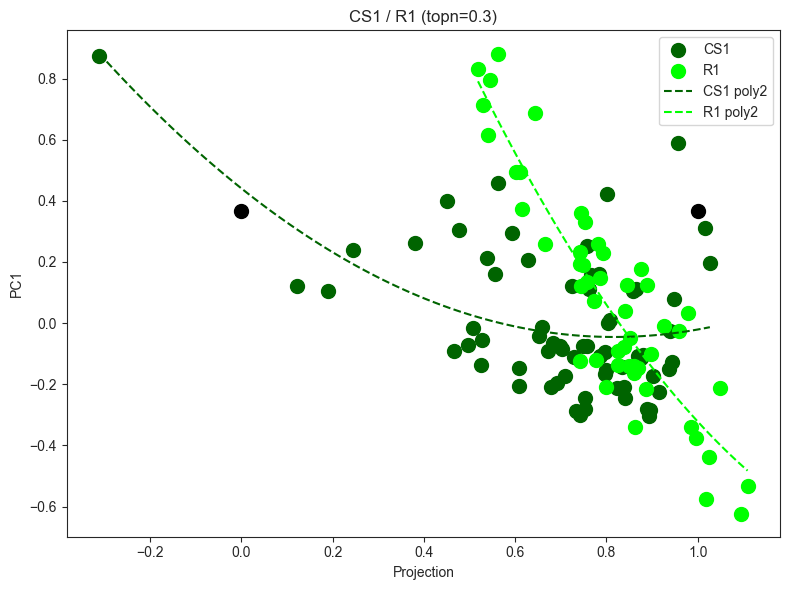

In [559]:
fig, ax = plt.subplots(figsize=(8, 6))
degree = 2

import matplotlib
matplotlib.rcParams['path.simplify'] = False

# Scatter plots for CS1 and R1
ax.scatter(proj_cs_1, pc_cs_1, color='darkgreen', s=100, label='CS1')
ax.scatter(proj_r_1, pc_r_1, color='lime', s=100, label='R1')

# Mark means of first and last 3 trials for CS1
ax.plot(np.mean(proj_cs_1[0:3]), np.mean(pc_cs_1[0:3]), color='k', marker='o', markersize=10)
ax.plot(np.mean(proj_cs_1[-3:]), np.mean(pc_cs_1[-3:]), color='k', marker='o', markersize=10)

# Polyfit for CS1
coeffs_cs1 = np.polyfit(proj_cs_1, pc_cs_1, degree)
x_fit_cs1 = np.linspace(proj_cs_1.min(), proj_cs_1.max(), 100)
y_fit_cs1 = np.polyval(coeffs_cs1, x_fit_cs1)
ax.plot(x_fit_cs1, y_fit_cs1, color='darkgreen', linestyle='--', label='CS1 poly2')

# Polyfit for R1
if len(proj_r_1) > 1:
    coeffs_r1 = np.polyfit(proj_r_1, pc_r_1, degree)
    x_fit_r1 = np.linspace(proj_r_1.min(), proj_r_1.max(), 100)
    y_fit_r1 = np.polyval(coeffs_r1, x_fit_r1)
    ax.plot(x_fit_r1, y_fit_r1, color='lime', linestyle='--', label='R1 poly2')

ax.set_title('CS1 / R1 (topn=0.3)')
ax.set_xlabel('Projection')
ax.set_ylabel('PC1')
ax.legend(loc='best', fontsize=10)
plt.tight_layout()
fig.savefig("pca_points.svg", format="svg")
plt.show()


## R^2 summary plot

In [560]:
from sklearn.decomposition import PCA

n_components = 60
topn = 0.3

top_n_1_idxs = np.argsort(late_cs1)[-int(len(late_cs1) * topn):]
top_n_2_idxs = np.argsort(late_cs2)[-int(len(late_cs2) * topn):]

mean_activity_cstopn_1 = mean_activity_cs_1[:, top_n_1_idxs]
mean_activity_cstopn_2 = mean_activity_cs_2[:, top_n_2_idxs]
mean_activity_rtopn_1 = mean_activity_r_1[:, top_n_1_idxs]
mean_activity_rtopn_2 = mean_activity_r_2[:, top_n_2_idxs]

early_topn_1 = early_cs1[top_n_1_idxs]
early_topn_2 = early_cs2[top_n_2_idxs]
late_topn_1 = late_cs1[top_n_1_idxs]
late_topn_2 = late_cs2[top_n_2_idxs]

late_1_centered = late_topn_1 - early_topn_1
late_2_centered = late_topn_2 - early_topn_2

cs_1_centered = mean_activity_cstopn_1 - early_topn_1
cs_2_centered = mean_activity_cstopn_2 - early_topn_2
r_1_centered = mean_activity_rtopn_1 - early_topn_1
r_2_centered = mean_activity_rtopn_2 - early_topn_2

proj_cs_1 = np.dot(cs_1_centered, late_1_centered)
proj_cs_2 = np.dot(cs_2_centered, late_2_centered)
proj_r_1 = np.dot(r_1_centered, late_1_centered)
proj_r_2 = np.dot(r_2_centered, late_2_centered)

residual_cs_1 = cs_1_centered - np.outer(proj_cs_1, late_1_centered)
residual_cs_2 = cs_2_centered - np.outer(proj_cs_2, late_2_centered)
residual_r_1 = r_1_centered - np.outer(proj_r_1, late_1_centered)
residual_r_2 = r_2_centered - np.outer(proj_r_2, late_2_centered)

pca_1 = PCA(n_components=n_components)
pca_2 = PCA(n_components=n_components)
pca_1.fit(residual_cs_1)
pca_2.fit(residual_cs_2)

pc_cs_1 = pca_1.transform(residual_cs_1)
pc_cs_2 = pca_2.transform(residual_cs_2)
pc_r_1 = pca_1.transform(residual_r_1)
pc_r_2 = pca_2.transform(residual_r_2)

# Combine early-to-late projections with PCA residuals
combined_cs_1 = np.hstack([proj_cs_1[:, np.newaxis], pc_cs_1])
combined_cs_2 = np.hstack([proj_cs_2[:, np.newaxis], pc_cs_2])
combined_r_1 = np.hstack([proj_r_1[:, np.newaxis], pc_r_1])
combined_r_2 = np.hstack([proj_r_2[:, np.newaxis], pc_r_2])

# Explained variance
variances_1 = np.var(combined_cs_1, axis=0)
total_variance_1 = np.sum(variances_1)
explained_variance_ratio_1 = variances_1 / total_variance_1

variances_2 = np.var(combined_cs_2, axis=0)
total_variance_2 = np.sum(variances_2)
explained_variance_ratio_2 = variances_2 / total_variance_2

# Cumulative explained variance
cumulative_variance_ratio_1 = np.cumsum(explained_variance_ratio_1)
cumulative_variance_ratio_2 = np.cumsum(explained_variance_ratio_2)

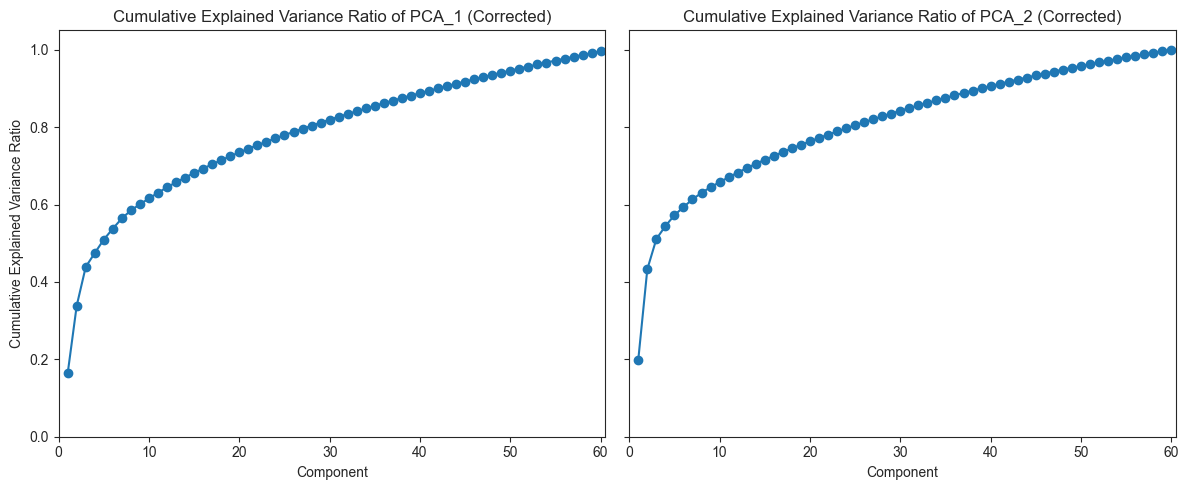

In [561]:
# Plotting
fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharey=True)

# Plot for PCA_1
axes[0].plot(
    range(1, len(cumulative_variance_ratio_1) + 1),
    list(cumulative_variance_ratio_1),
    marker='o'
)
axes[0].set_xlabel('Component')
axes[0].set_ylabel('Cumulative Explained Variance Ratio')
axes[0].set_title('Cumulative Explained Variance Ratio of PCA_1 (Corrected)')
axes[0].set_xlim((0, 60.5))
axes[0].set_ylim((0, 1.05))

# Plot for PCA_2
axes[1].plot(
    range(1, len(cumulative_variance_ratio_2) + 1),
    list(cumulative_variance_ratio_2),
    marker='o'
)
axes[1].set_xlabel('Component')
axes[1].set_title('Cumulative Explained Variance Ratio of PCA_2 (Corrected)')
axes[1].set_xlim((0, 60.5))

plt.tight_layout()
plt.savefig('figs/cumulative_explained_var_pca_2col_corrected.svg', format='svg', bbox_inches="tight")
plt.show()

## Distances per component

In [633]:
# Signal-to-Noise correction for all components
# Use both CS and R for covariance estimation
combined_1 = np.vstack([combined_r_1])
combined_2 = np.vstack([combined_r_2])

cov_matrix_1 = np.cov(combined_1.T)
cov_matrix_2 = np.cov(combined_2.T)

# Calculate cumulative Euclidean distances in corrected space for TL and BP hypotheses
Nr = 13  # number of first stimulus presentations/reactivations to consider

idx_cs_for_r_1 = trial_r_1[:Nr]
idx_cs_for_r_2 = trial_r_2[:Nr]

consider_cs_1 = combined_cs_1[idx_cs_for_r_1]
consider_cs_2 = combined_cs_2[idx_cs_for_r_2]
consider_r_1 = combined_r_1[:Nr]
consider_r_2 = combined_r_2[:Nr]

late_1 = np.mean(combined_cs_1[-3:], axis=0)
late_2 = np.mean(combined_cs_2[-3:], axis=0)

# Calculate mean distances per component for TL and BP hypotheses
dist_tl_1 = np.zeros((n_components+1))
dist_tl_2 = np.zeros((n_components+1))
dist_bp_1 = np.zeros((n_components+1))
dist_bp_2 = np.zeros((n_components+1))

for i in range(1, n_components+2):
    dist_tl_1[i-1] = np.mean(np.sqrt(np.sum(np.square(consider_r_1[:, :i] - late_1[:i]) / np.diag(cov_matrix_1[:i,:i]), axis=1)))
    dist_tl_2[i-1] = np.mean(np.sqrt(np.sum(np.square(consider_r_2[:, :i] - late_2[:i]) / np.diag(cov_matrix_2[:i,:i]), axis=1)))
    dist_bp_1[i-1] = np.mean(np.sqrt(np.sum(np.square(consider_r_1[:, :i] - consider_cs_1[:, :i]) / np.diag(cov_matrix_1[:i,:i]), axis=1)))
    dist_bp_2[i-1] = np.mean(np.sqrt(np.sum(np.square(consider_r_2[:, :i] - consider_cs_2[:, :i]) / np.diag(cov_matrix_2[:i,:i]), axis=1)))

([<matplotlib.lines.Line2D at 0x314c07f90>],
 (61,),
 (61,),
 (13, 61))

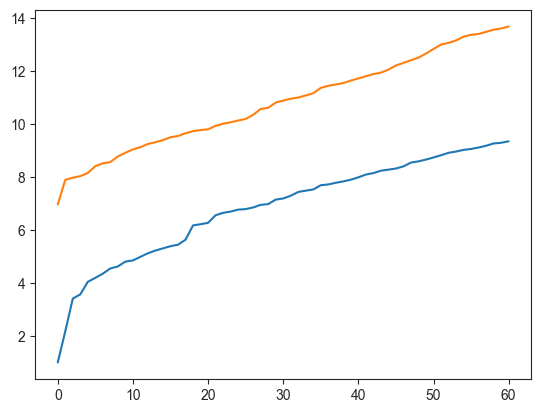

In [634]:
plt.plot(dist_tl_1), plt.plot(dist_bp_1), dist_tl_1.shape, cumulative_variance_ratio_1.shape, consider_r_1.shape

In [639]:
cumulative_variance_ratio_2

array([0.19926772, 0.43298632, 0.51091673, 0.5444638 , 0.57227183,
       0.59370108, 0.61327708, 0.63037056, 0.64468005, 0.65791781,
       0.67049285, 0.68256182, 0.69406211, 0.70523511, 0.71567754,
       0.7257957 , 0.73556822, 0.74523391, 0.75438664, 0.76321235,
       0.77192106, 0.78050346, 0.7887955 , 0.79687932, 0.80488693,
       0.81275596, 0.82042884, 0.82787295, 0.8351395 , 0.84225741,
       0.84925348, 0.85597261, 0.86258652, 0.86913426, 0.87563581,
       0.88198014, 0.88823534, 0.8943994 , 0.90027975, 0.90612205,
       0.9117778 , 0.91734759, 0.92280269, 0.92821593, 0.93350025,
       0.9386239 , 0.9435957 , 0.94854855, 0.95336717, 0.95797975,
       0.96256197, 0.96710594, 0.97161626, 0.97601766, 0.98025586,
       0.98445042, 0.98855532, 0.99246708, 0.9962803 , 1.        ,
       1.        ])

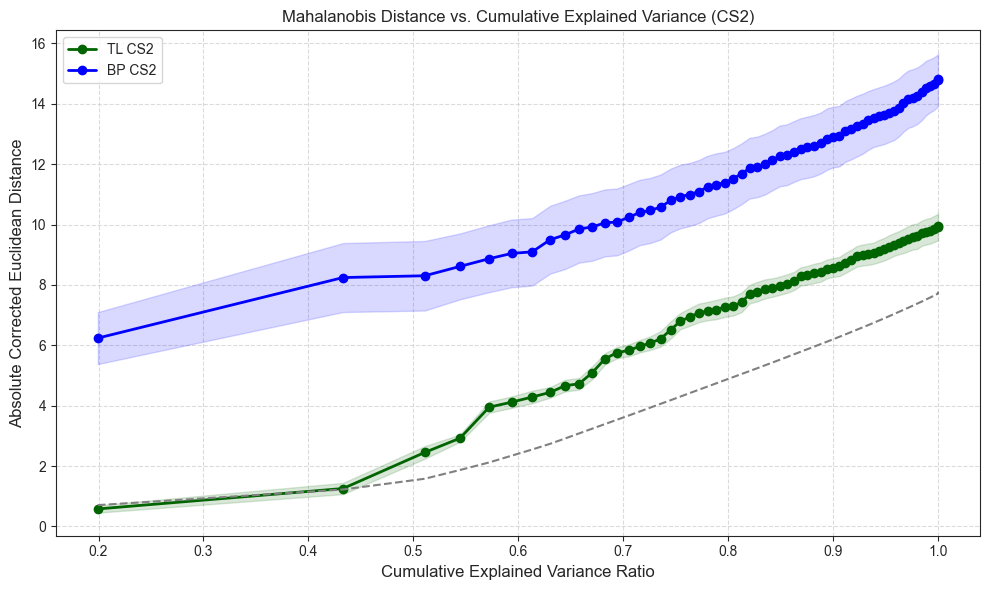

In [640]:
import numpy as np
import matplotlib.pyplot as plt

# Assume existing variables: consider_r_1, consider_cs_1, late_1, cov_matrix_1,
# consider_r_2, consider_cs_2, late_2, cov_matrix_2, Nr, n_components,
# cumulative_variance_ratio_1, cumulative_variance_ratio_2,
# dist_tl_1, dist_bp_1, dist_tl_2, dist_bp_2

# Compute standard error for each dimension
sem_tl_1 = np.zeros(n_components + 1)
sem_bp_1 = np.zeros(n_components + 1)
sem_tl_2 = np.zeros(n_components + 1)
sem_bp_2 = np.zeros(n_components + 1)

for i in range(1, n_components + 2):
    # Expected distance for dimension i
    expected_distance = np.sqrt(i - 1/2)
    
    # CS1: Compute distances for each of the Nr pairs
    dist_tl_1_i = np.sqrt(np.sum(np.square(consider_r_1[:, :i] - late_1[:i]) / np.diag(cov_matrix_1[:i, :i]), axis=1))
    dist_bp_1_i = np.sqrt(np.sum(np.square(consider_r_1[:, :i] - consider_cs_1[:, :i]) / np.diag(cov_matrix_1[:i, :i]), axis=1))
    corrected_tl_1_i = dist_tl_1_i - expected_distance
    corrected_bp_1_i = dist_bp_1_i - expected_distance
    
    # CS2: Compute distances for each of the Nr pairs
    dist_tl_2_i = np.sqrt(np.sum(np.square(consider_r_2[:, :i] - late_2[:i]) / np.diag(cov_matrix_2[:i, :i]), axis=1))
    dist_bp_2_i = np.sqrt(np.sum(np.square(consider_r_2[:, :i] - consider_cs_2[:, :i]) / np.diag(cov_matrix_2[:i, :i]), axis=1))
    corrected_tl_2_i = dist_tl_2_i - expected_distance
    corrected_bp_2_i = dist_bp_2_i - expected_distance
    
    # Compute standard error (std / sqrt(Nr))
    sem_tl_1[i-1] = np.std(corrected_tl_1_i) / np.sqrt(Nr)
    sem_bp_1[i-1] = np.std(corrected_bp_1_i) / np.sqrt(Nr)
    sem_tl_2[i-1] = np.std(corrected_tl_2_i) / np.sqrt(Nr)
    sem_bp_2[i-1] = np.std(corrected_bp_2_i) / np.sqrt(Nr)

# Plot with shaded standard error areas
plt.figure(figsize=(10, 6))
# CS1 TL
mean_tl_1 = dist_tl_1 #- np.sqrt(2 * np.arange(1, n_components + 2) - 1)
# plt.plot(cumulative_variance_ratio_1, mean_tl_1, label='TL CS1', c='darkgreen', linewidth=2)
# plt.fill_between(cumulative_variance_ratio_1, mean_tl_1 - sem_tl_1, mean_tl_1 + sem_tl_1, 
#                  color='darkgreen', alpha=0.3)
# CS1 BP
mean_bp_1 = dist_bp_1 #- np.sqrt(2 * np.arange(1, n_components + 2) - 1)
# plt.plot(cumulative_variance_ratio_1, mean_bp_1, label='BP CS1', c='blue', linewidth=2)
# plt.fill_between(cumulative_variance_ratio_1, mean_bp_1 - sem_bp_1, mean_bp_1 + sem_bp_1, 
#                  color='blue', alpha=0.3)
# CS2 TL
mean_tl_2 = dist_tl_2 #- np.sqrt(2 * np.arange(1, n_components + 2) - 1)
plt.plot(cumulative_variance_ratio_2, mean_tl_2, label='TL CS2', c='darkgreen', linewidth=2, marker='o')
plt.fill_between(cumulative_variance_ratio_2, mean_tl_2 - sem_tl_2, mean_tl_2 + sem_tl_2, 
                 color='darkgreen', alpha=0.15)
# CS2 BP
mean_bp_2 = dist_bp_2# - np.sqrt(2 * np.arange(1, n_components + 2) - 1)
plt.plot(cumulative_variance_ratio_2, mean_bp_2, label='BP CS2', c='blue', linewidth=2, marker='o')
plt.fill_between(cumulative_variance_ratio_2, mean_bp_2 - sem_bp_2, mean_bp_2 + sem_bp_2, 
                 color='blue', alpha=0.15)
# Expected distance
# plt.plot(cumulative_variance_ratio_1, np.sqrt(np.arange(1, n_components + 2) - 1/2), 
#          color='gray', label='Expected Distance')
plt.plot(cumulative_variance_ratio_2, np.sqrt(np.arange(1, n_components + 2) - 1/2), 
         color='gray', linestyle='--')
plt.xlabel('Cumulative Explained Variance Ratio', fontsize=12)
plt.ylabel('Absolute Corrected Euclidean Distance', fontsize=12)
plt.title('Mahalanobis Distance vs. Cumulative Explained Variance (CS2)')
plt.savefig("mahalanobis.svg", format="svg", bbox_inches="tight")
plt.legend(fontsize=10)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

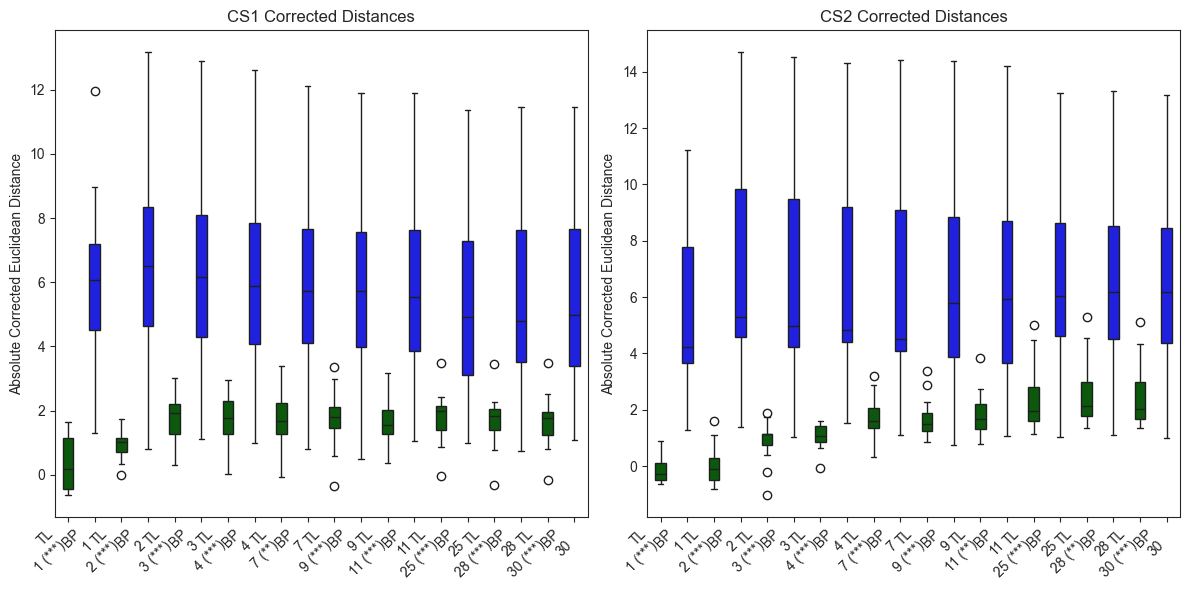

Wilcoxon p-values and Statistics (alpha = 0.050):
Dimension | CS1 p-value | CS1 Significance | CS1 TL Mean | CS1 TL Std | CS1 BP Mean | CS1 BP Std | CS2 p-value | CS2 Significance | CS2 TL Mean | CS2 TL Std | CS2 BP Mean | CS2 BP Std
------------------------------------------------------------------------------------------------------------------------
       1 | 2.441e-04 | ***              | 0.282 | 0.767 | 6.247 | 2.612 | 2.441e-04 | ***              | -0.126 | 0.447 | 5.533 | 3.105
       2 | 2.441e-04 | ***              | 0.943 | 0.450 | 6.656 | 3.053 | 2.441e-04 | ***              | 0.033 | 0.670 | 7.021 | 4.119
       3 | 2.441e-04 | ***              | 1.819 | 0.767 | 6.381 | 2.977 | 4.883e-04 | ***              | 0.872 | 0.749 | 6.724 | 4.155
       4 | 2.441e-04 | ***              | 1.688 | 0.812 | 6.151 | 2.927 | 2.441e-04 | ***              | 1.053 | 0.440 | 6.744 | 3.936
       5 | 2.441e-04 | ***              | 1.913 | 0.971 | 6.018 | 2.994 | 4.883e-04 | ***              |

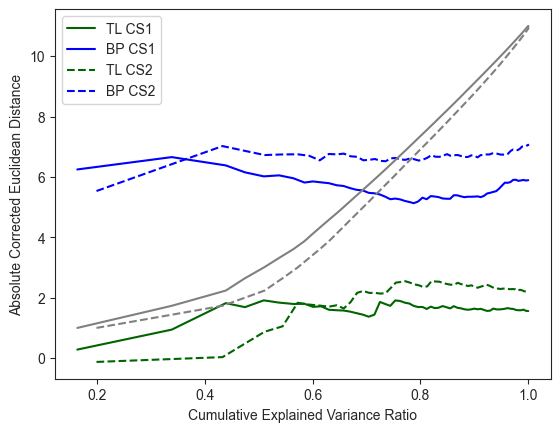

In [636]:
import numpy as np
from scipy.stats import wilcoxon
import matplotlib.pyplot as plt
import seaborn as sns

# Assume existing variables: consider_r_1, consider_cs_1, late_1, cov_matrix_1,
# consider_r_2, consider_cs_2, late_2, cov_matrix_2, Nr, n_components,
# cumulative_variance_ratio_1, cumulative_variance_ratio_2

# Initialize arrays for per-dimension p-values and distances
p_values_cs1_wilcoxon = np.zeros(n_components + 1)
p_values_cs2_wilcoxon = np.zeros(n_components + 1)
corrected_distances_tl_1 = [[] for _ in range(n_components + 1)]
corrected_distances_bp_1 = [[] for _ in range(n_components + 1)]
corrected_distances_tl_2 = [[] for _ in range(n_components + 1)]
corrected_distances_bp_2 = [[] for _ in range(n_components + 1)]
mean_corrected_tl_1 = np.zeros(n_components + 1)
mean_corrected_bp_1 = np.zeros(n_components + 1)
mean_corrected_tl_2 = np.zeros(n_components + 1)
mean_corrected_bp_2 = np.zeros(n_components + 1)
std_corrected_tl_1 = np.zeros(n_components + 1)
std_corrected_bp_1 = np.zeros(n_components + 1)
std_corrected_tl_2 = np.zeros(n_components + 1)
std_corrected_bp_2 = np.zeros(n_components + 1)

# Significance thresholds
alpha_3 = 0.001  # ***
alpha_2 = 0.01   # **
alpha_1 = 0.05   # *

# Compute distances and p-values for each dimension
for i in range(1, n_components + 2):
    # Expected distance for dimension i
    expected_distance = np.sqrt(i - 1/2)
    
    # CS1: Compute distances for each of the Nr pairs
    dist_tl_1_i = np.sqrt(np.sum(np.square(consider_r_1[:, :i] - late_1[:i]) / np.diag(cov_matrix_1[:i, :i]), axis=1))
    dist_bp_1_i = np.sqrt(np.sum(np.square(consider_r_1[:, :i] - consider_cs_1[:, :i]) / np.diag(cov_matrix_1[:i, :i]), axis=1))
    corrected_tl_1_i = dist_tl_1_i - expected_distance
    corrected_bp_1_i = dist_bp_1_i - expected_distance

    # CS2: Compute distances for each of the Nr pairs
    dist_tl_2_i = np.sqrt(np.sum(np.square(consider_r_2[:, :i] - late_2[:i]) / np.diag(cov_matrix_2[:i, :i]), axis=1))
    dist_bp_2_i = np.sqrt(np.sum(np.square(consider_r_2[:, :i] - consider_cs_2[:, :i]) / np.diag(cov_matrix_2[:i, :i]), axis=1))
    corrected_tl_2_i = dist_tl_2_i - expected_distance
    corrected_bp_2_i = dist_bp_2_i - expected_distance
    
    # Store distances and statistics
    corrected_distances_tl_1[i-1] = corrected_tl_1_i
    corrected_distances_bp_1[i-1] = corrected_bp_1_i
    corrected_distances_tl_2[i-1] = corrected_tl_2_i
    corrected_distances_bp_2[i-1] = corrected_bp_2_i
    mean_corrected_tl_1[i-1] = np.mean(corrected_tl_1_i)
    mean_corrected_bp_1[i-1] = np.mean(corrected_bp_1_i)
    mean_corrected_tl_2[i-1] = np.mean(corrected_tl_2_i)
    mean_corrected_bp_2[i-1] = np.mean(corrected_bp_2_i)
    std_corrected_tl_1[i-1] = np.std(corrected_tl_1_i)
    std_corrected_bp_1[i-1] = np.std(corrected_bp_1_i)
    std_corrected_tl_2[i-1] = np.std(corrected_tl_2_i)
    std_corrected_bp_2[i-1] = np.std(corrected_bp_2_i)
    
    # Wilcoxon signed-rank test
    try:
        w_stat_cs1, p_values_cs1_wilcoxon[i-1] = wilcoxon(corrected_tl_1_i, corrected_bp_1_i)
    except ValueError:
        p_values_cs1_wilcoxon[i-1] = 1.0
    try:
        w_stat_cs2, p_values_cs2_wilcoxon[i-1] = wilcoxon(corrected_tl_2_i, corrected_bp_2_i)
    except ValueError:
        p_values_cs2_wilcoxon[i-1] = 1.0

# Determine significance levels and transition points
def get_significance_level(p):
    if p < alpha_3:
        return '***'
    elif p < alpha_2:
        return '**'
    elif p < alpha_1:
        return '*'
    return ''

# Find components where significance changes (for CS1 and CS2 combined)
sig_levels_cs1 = [get_significance_level(p) for p in p_values_cs1_wilcoxon]
sig_levels_cs2 = [get_significance_level(p) for p in p_values_cs2_wilcoxon]
components_to_plot = [1, 2, 3, 4]  # First 4 components
for i in range(1, n_components + 1):
    # Check transitions in either CS1 or CS2
    if (sig_levels_cs1[i-1] != sig_levels_cs1[i] or sig_levels_cs2[i-1] != sig_levels_cs2[i]) and i + 1 not in components_to_plot:
        components_to_plot.append(i + 1)

# Create boxplots
plt.figure(figsize=(12, 6))
for idx, condition in enumerate(['CS1', 'CS2']):
    plt.subplot(1, 2, idx + 1)
    data = []
    labels = []
    positions = []
    pos_offset = 0
    for i in components_to_plot:
        n = i - 1
        # Collect distances for TL and BP
        if condition == 'CS1':
            data.extend([corrected_distances_tl_1[n], corrected_distances_bp_1[n]])
            sig = sig_levels_cs1[n]
        else:
            data.extend([corrected_distances_tl_2[n], corrected_distances_bp_2[n]])
            sig = sig_levels_cs2[n]
        labels.extend([f'TL\n{i} ({sig})', f'BP\n{i}'])
        positions.extend([pos_offset, pos_offset + 0.4])
        pos_offset += 1.0
    
    # Boxplot
    sns.boxplot(data=data, palette=['darkgreen', 'blue'] * len(components_to_plot), width=0.4, showmeans=False)
                # meanprops={'marker': 'o', 'markerfacecolor': 'white', 'markeredgecolor': 'black'})
    plt.xticks(range(len(labels)), labels, rotation=45, ha='right')
    plt.title(f'{condition} Corrected Distances')
    plt.ylabel('Absolute Corrected Euclidean Distance')
    plt.tight_layout()

plt.show()

# Print p-values and statistics
print(f"Wilcoxon p-values and Statistics (alpha = {alpha_1:.3f}):")
print("Dimension | CS1 p-value | CS1 Significance | CS1 TL Mean | CS1 TL Std | CS1 BP Mean | CS1 BP Std | "
      "CS2 p-value | CS2 Significance | CS2 TL Mean | CS2 TL Std | CS2 BP Mean | CS2 BP Std")
print("-" * 120)
for i in range(n_components + 1):
    cs1_sig = get_significance_level(p_values_cs1_wilcoxon[i])
    cs2_sig = get_significance_level(p_values_cs2_wilcoxon[i])
    print(f"{i+1:8d} | {p_values_cs1_wilcoxon[i]:.3e} | {cs1_sig:16s} | {mean_corrected_tl_1[i]:.3f} | {std_corrected_tl_1[i]:.3f} | "
          f"{mean_corrected_bp_1[i]:.3f} | {std_corrected_bp_1[i]:.3f} | "
          f"{p_values_cs2_wilcoxon[i]:.3e} | {cs2_sig:16s} | {mean_corrected_tl_2[i]:.3f} | {std_corrected_tl_2[i]:.3f} | "
          f"{mean_corrected_bp_2[i]:.3f} | {std_corrected_bp_2[i]:.3f}")

# Reproduce original line plot
plt.figure()
plt.plot(cumulative_variance_ratio_1, mean_corrected_tl_1, label='TL CS1', c='darkgreen')
plt.plot(cumulative_variance_ratio_1, mean_corrected_bp_1, label='BP CS1', c='blue')
plt.plot(cumulative_variance_ratio_2, mean_corrected_tl_2, label='TL CS2', c='darkgreen', linestyle='--')
plt.plot(cumulative_variance_ratio_2, mean_corrected_bp_2, label='BP CS2', c='blue', linestyle='--')
plt.plot(cumulative_variance_ratio_1, np.sqrt(2 * np.arange(1, n_components + 2) - 1), color='gray')
plt.plot(cumulative_variance_ratio_2, np.sqrt(2 * np.arange(1, n_components + 2) - 1), color='gray', linestyle='--')
plt.xlabel('Cumulative Explained Variance Ratio')
plt.ylabel('Absolute Corrected Euclidean Distance')
plt.legend()
plt.show()

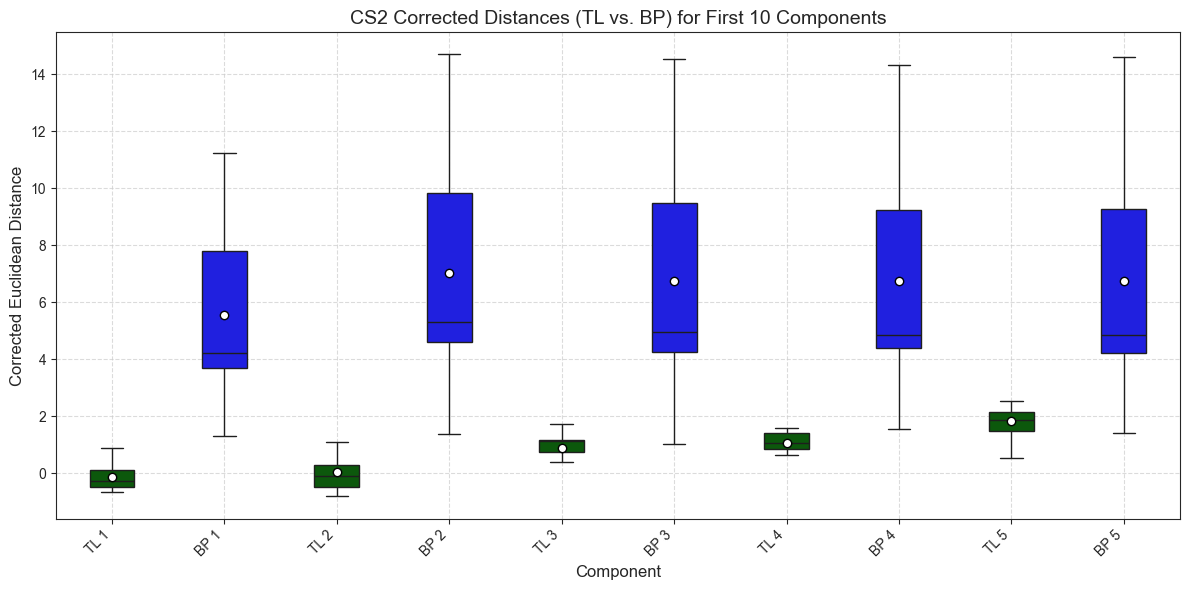

In [642]:
# Ensure max_components does not exceed available components
max_components = min(5, n_components + 1)

# Initialize lists to store corrected distances
corrected_distances_tl_2 = [[] for _ in range(max_components)]
corrected_distances_bp_2 = [[] for _ in range(max_components)]

# Compute corrected distances for each dimension
for i in range(1, max_components + 1):
    # Expected distance for dimension i
    expected_distance = np.sqrt(i - 0.5)
    
    # CS2: Compute distances for each of the Nr pairs
    dist_tl_2_i = np.sqrt(np.sum(np.square(consider_r_2[:, :i] - late_2[:i]) / np.diag(cov_matrix_2[:i, :i]), axis=1))
    dist_bp_2_i = np.sqrt(np.sum(np.square(consider_r_2[:, :i] - consider_cs_2[:, :i]) / np.diag(cov_matrix_2[:i, :i]), axis=1))
    corrected_tl_2_i = dist_tl_2_i - expected_distance
    corrected_bp_2_i = dist_bp_2_i - expected_distance
    
    # Store corrected distances
    corrected_distances_tl_2[i-1] = corrected_tl_2_i
    corrected_distances_bp_2[i-1] = corrected_bp_2_i

# Prepare data for boxplots
data = []
labels = []
for i in range(max_components):
    data.extend([corrected_distances_tl_2[i], corrected_distances_bp_2[i]])
    labels.extend([f'TL {i+1}', f'BP {i+1}'])

# Create boxplot with mean marker and no outlier markers
plt.figure(figsize=(12, 6))
sns.boxplot(
    data=data,
    palette=['darkgreen', 'blue'] * max_components,
    width=0.4,
    showmeans=True,
    meanprops={'marker': 'o', 'markerfacecolor': 'white', 'markeredgecolor': 'black'},
    showfliers=False  # Do not show outlier markers
)
plt.xticks(range(len(labels)), labels, rotation=45, ha='right', fontsize=10)
plt.xlabel('Component', fontsize=12)
plt.ylabel('Corrected Euclidean Distance', fontsize=12)
plt.title('CS2 Corrected Distances (TL vs. BP) for First 10 Components', fontsize=14)
plt.savefig("boxplots.svg", format="svg", bbox_inches="tight")
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()